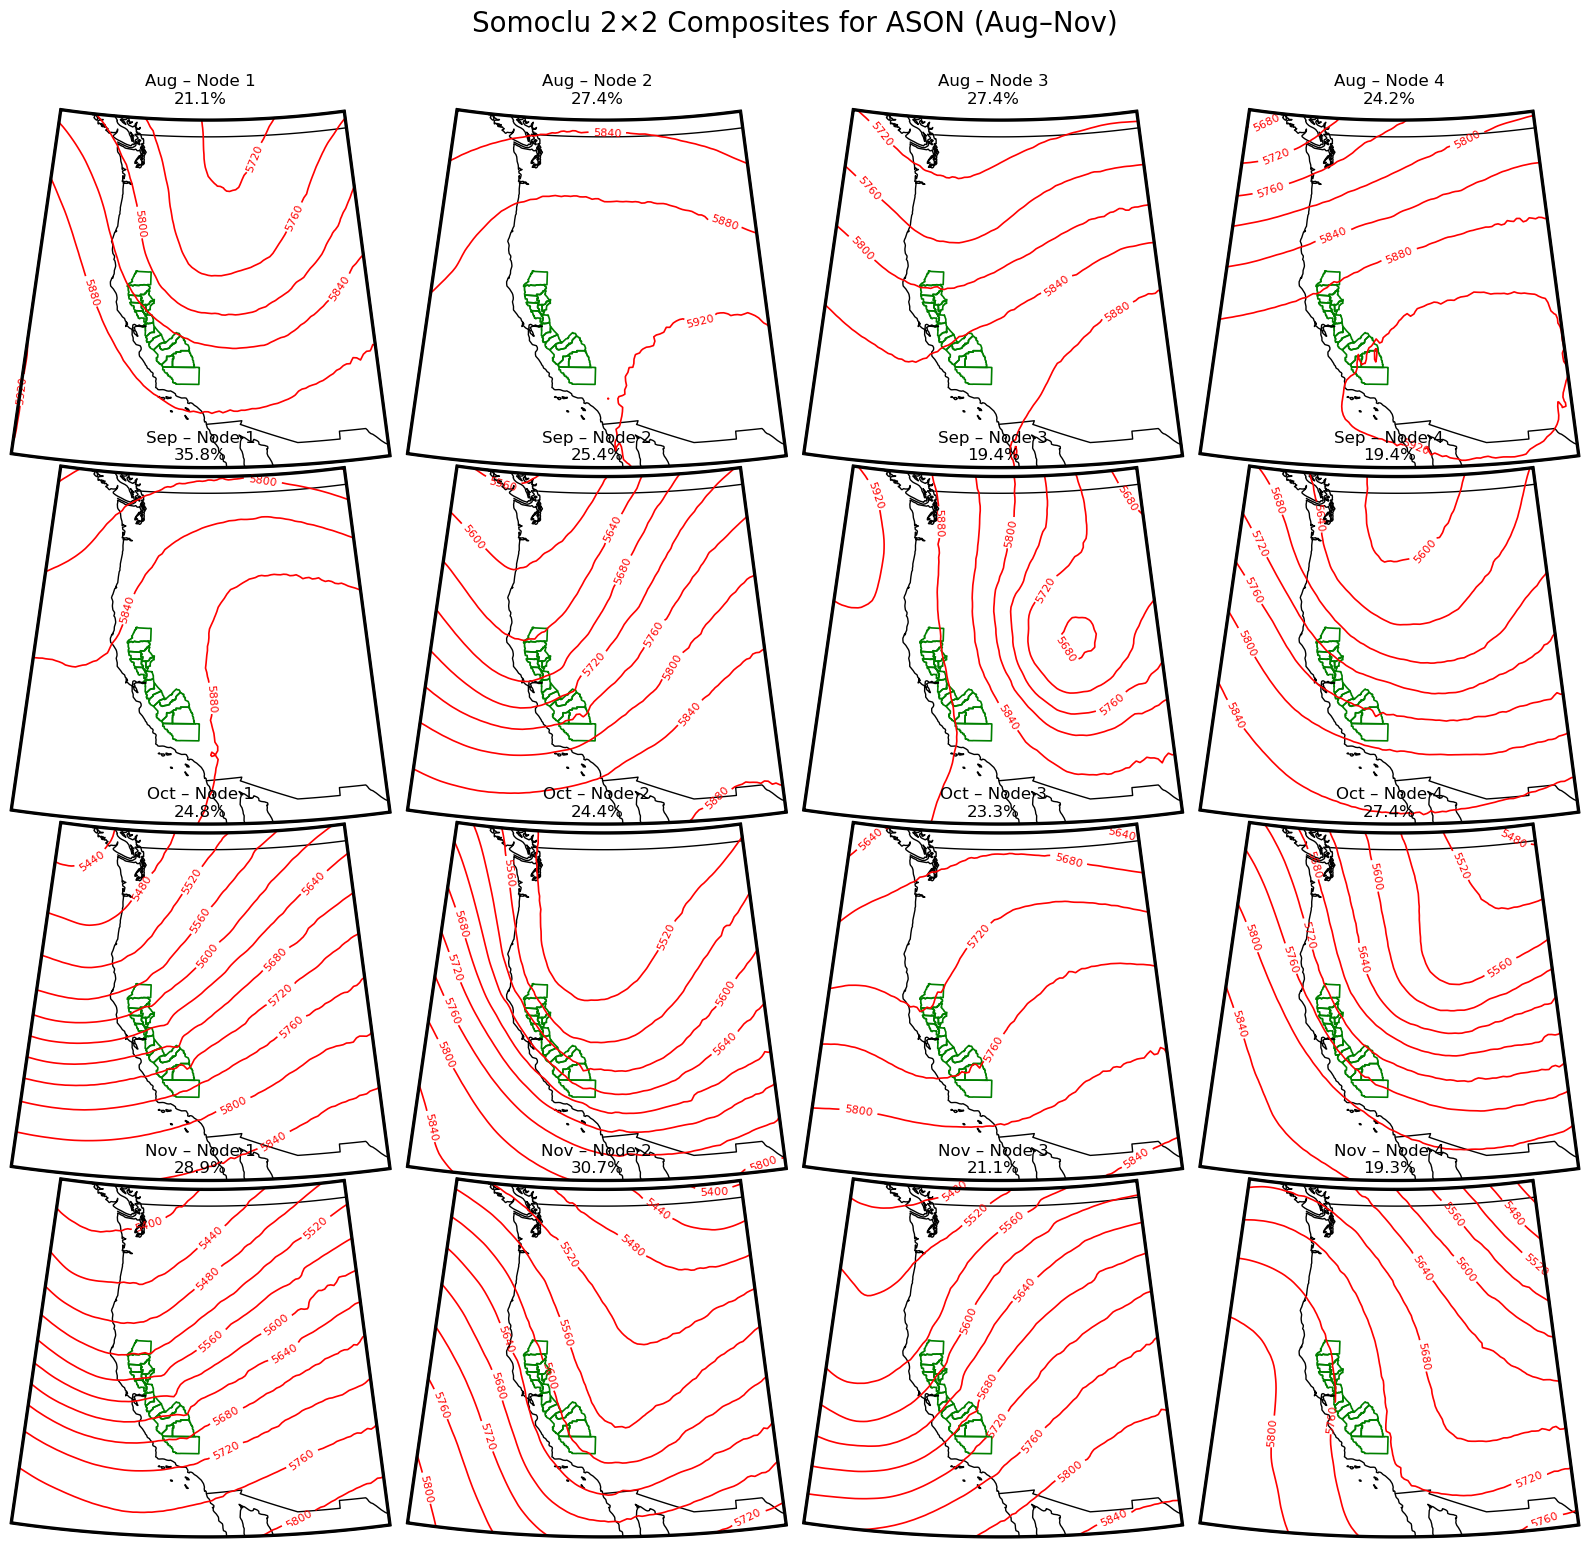

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import geopandas as gpd
from somoclu import Somoclu

# 0) same curved box as before
lon0, lon1 = -130, -105
lat0, lat1 =   30,   50
n = 200
top    = np.column_stack((np.linspace(lon0, lon1, n), [lat1]*n))
right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
bottom = np.column_stack((np.linspace(lon1, lon0, n), [lat0]*n))
left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
pts    = np.vstack([top, right, bottom, left, top[:1]])
codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
box_path = Path(pts, codes)
def clip_to_curve(ax, linewidth=4, edgecolor="black"):
    ax.set_boundary(box_path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(box_path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

# 1) load Central Valley
cv_gdf = gpd.read_file("central_valley_counties.shp")

# 2) load your Z500 file and convert to geopotential (and subset pressure level)
ds = xr.open_dataset("z_dust.nc")
z  = ds["z"] / 9.8
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

# 3) specify ASON months
ason_months = [8, 9, 10, 11]
ason_names  = ["Aug","Sep","Oct","Nov"]

# pre-allocate storage
comps_all = {}
freqs_all = {}

# loop over each month and train a separate 2×2 SOM just like before
for month, mname in zip(ason_months, ason_names):
    # select only that month & your CV box
    zmon = (
        z
        .sel(valid_time=z.valid_time.dt.month == month)
        .where((z.latitude >= lat0)&(z.latitude <= lat1), drop=True)
        .where((z.longitude>=lon0)&(z.longitude<=lon1), drop=True)
    )
    data  = zmon.values            # (time, lat, lon)
    nt, ny, nx = data.shape
    flat  = data.reshape(nt, ny*nx)

    # train SOM
    som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
    np.random.seed(0)
    som.train(flat, epochs=1000)
    labels = som.bmus[:,0]*2 + som.bmus[:,1]

    # composite & freq
    comps, freqs = {}, {}
    for node in range(4):
        mask = labels == node
        freqs[node] = mask.sum()/nt*100
        if mask.any():
            comps[node] = np.nanmean(data[mask], axis=0)
        else:
            comps[node] = np.full((ny, nx), np.nan)
    comps_all[month] = comps
    freqs_all[month] = freqs

# determine contour levels on the full ASON range
all_min = min(np.nanmin(c) for month in ason_months for c in comps_all[month].values())
all_max = max(np.nanmax(c) for month in ason_months for c in comps_all[month].values())
levels  = np.arange((all_min//40)*40, (all_max//40+1)*40 + 1, 40)

# build lon/lat mesh once
lons = zmon.longitude.values
lats = zmon.latitude.values
lon2d, lat2d = np.meshgrid(lons, lats)

# projection
proj = ccrs.LambertConformal(
    central_longitude=-117,
    central_latitude=35,
    standard_parallels=(33,45)
)

# 4×4 mosaic: 4 months × 4 nodes
fig, axes = plt.subplots(
    nrows=4, ncols=4,
    figsize=(16,16),
    subplot_kw={"projection": proj}
)
plt.tight_layout(rect=[0,0,1,0.95])

for i, month in enumerate(ason_months):
    for node in range(4):
        ax = axes[i, node]
        clip_to_curve(ax)
        ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())

        # contour the composite for this (month, node)
        cs = ax.contour(
            lon2d, lat2d, comps_all[month][node],
            levels=levels,
            colors="red", linewidths=1.2,
            transform=ccrs.PlateCarree()
        )
        ax.clabel(cs, fmt="%d", fontsize=8)

        # overlay CV counties & coastlines/borders
        ax.add_geometries(
            cv_gdf.geometry,
            crs=ccrs.PlateCarree(),
            edgecolor="green", facecolor="none", linewidth=1.2
        )
        ax.coastlines(resolution="50m", linewidth=1)
        ax.add_feature(cfeature.BORDERS, linewidth=1)

        # title = Node & Month & frequency
        ax.set_title(
            f"{ason_names[i]} – Node {node+1}\n{freqs_all[month][node]:.1f}%",
            fontsize=12, pad=4
        )

fig.suptitle("Somoclu 2×2 Composites for ASON (Aug–Nov)", fontsize=20)
fig.savefig("som_2x2_ASON_Aug_Nov.png", dpi=300, bbox_inches="tight")
plt.show()


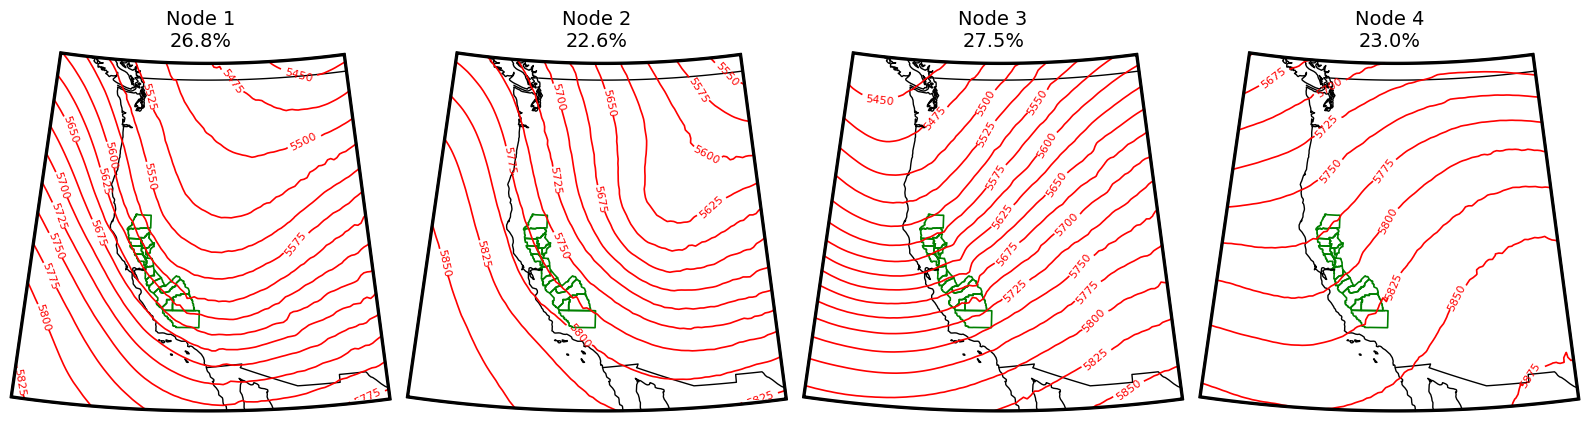

In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import geopandas as gpd
from somoclu import Somoclu

# 0) curved “box” boundary (unchanged)
lon0, lon1 = -130, -105
lat0, lat1 =   30,   50
n = 200
top    = np.column_stack((np.linspace(lon0, lon1, n), [lat1]*n))
right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
bottom = np.column_stack((np.linspace(lon1, lon0, n), [lat0]*n))
left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
pts    = np.vstack([top, right, bottom, left, top[:1]])
codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
box_path = Path(pts, codes)
def clip_to_curve(ax, linewidth=4, edgecolor="black"):
    ax.set_boundary(box_path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(box_path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

# 1) CV shapefile
cv_gdf = gpd.read_file("central_valley_counties.shp")

# 2) load geopotential z500
ds = xr.open_dataset("z_dust.nc")
z  = ds["z"] / 9.8
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

# 3) select ASON (Aug–Nov) all at once
ason = z.sel(valid_time=z.valid_time.dt.month.isin([9,10,11]))
ason = (
    ason
    .where((ason.latitude >= lat0)&(ason.latitude <= lat1), drop=True)
    .where((ason.longitude>=lon0)&(ason.longitude<=lon1), drop=True)
)

# flatten and train 2×2 SOM
data = ason.values               # shape (ntime, nlat, nlon)
ntime, nlat, nlon = data.shape
flat  = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

# compute composites & frequencies
labels = som.bmus[:,0] * 2 + som.bmus[:,1]
comps, freqs = {}, {}
for node in range(4):
    mask = (labels == node)
    freqs[node] = mask.sum() / ntime * 100
    comps[node] = np.nanmean(data[mask], axis=0) if mask.any() else np.full((nlat,nlon), np.nan)

# contour levels
vmin = min(np.nanmin(c) for c in comps.values())
vmax = max(np.nanmax(c) for c in comps.values())
levels = np.arange((vmin//25)*25, (vmax//25+1)*25 + 1, 25)

# prepare lon/lat grids & projection
lon2d, lat2d = np.meshgrid(ason.longitude, ason.latitude)
proj = ccrs.LambertConformal(central_longitude=-117, central_latitude=35,
                             standard_parallels=(33,45))

# 1×4 plot of the ASON composites
fig, axes = plt.subplots(1, 4, figsize=(16,6),
                         subplot_kw={"projection": proj})
plt.tight_layout(rect=[0,0,1,0.88])

for node, ax in enumerate(axes):
    clip_to_curve(ax)
    ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())

    cs = ax.contour(lon2d, lat2d, comps[node], levels=levels,
                    colors="red", linewidths=1.2, transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt="%d", fontsize=8)

    ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="green", facecolor="none", linewidth=1.2)
    ax.coastlines(resolution="50m", linewidth=1)
    ax.add_feature(cfeature.BORDERS, linewidth=1)

    ax.set_title(f"Node {node+1}\n{freqs[node]:.1f}%", fontsize=14, pad=4)

fig.suptitle("", fontsize=20)
fig.savefig("som_2x2_ASON_combined.png", dpi=500, bbox_inches="tight")
plt.show()


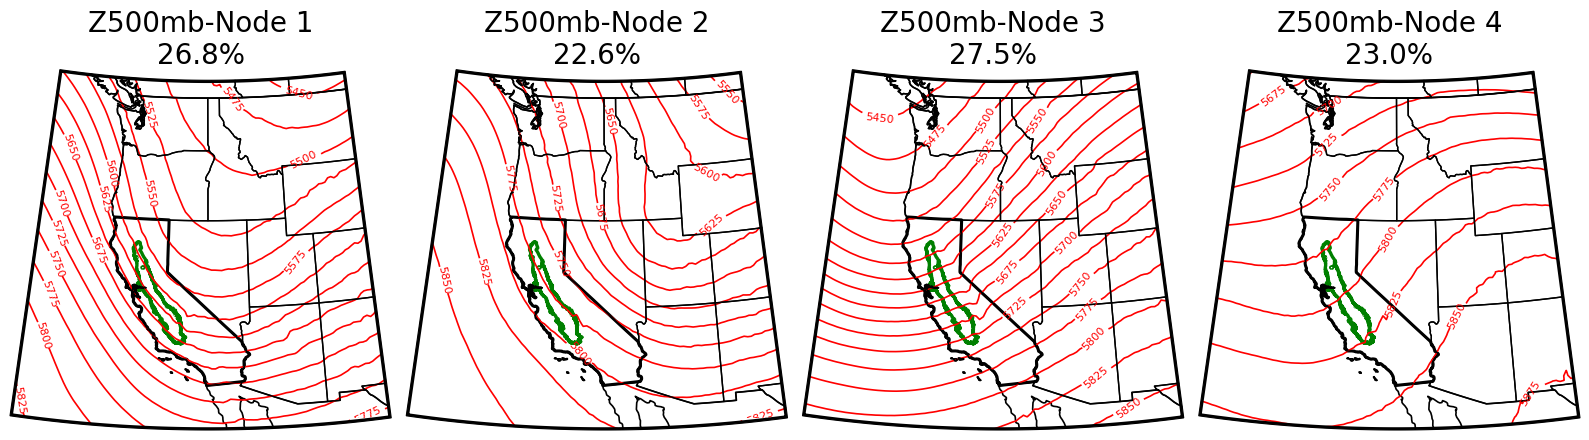

In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import geopandas as gpd
from somoclu import Somoclu

# 0) curved “box” boundary (unchanged)
lon0, lon1 = -130, -105
lat0, lat1 =   30,   50
n = 200
top    = np.column_stack((np.linspace(lon0, lon1, n), [lat1]*n))
right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
bottom = np.column_stack((np.linspace(lon1, lon0, n), [lat0]*n))
left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
pts    = np.vstack([top, right, bottom, left, top[:1]])
codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
box_path = Path(pts, codes)
def clip_to_curve(ax, linewidth=4, edgecolor="black"):
    ax.set_boundary(box_path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(box_path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

# 1) CV shapefile
cv_gdf = gpd.read_file("central_valley_alluvial_boundary_usgs.shp").to_crs(epsg=4326)
cv1_gdf = gpd.read_file("california_shapefile.shp").to_crs(epsg=4326)

# 2) load geopotential z500
ds = xr.open_dataset("z_dust.nc")
z  = ds["z"] / 9.8
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

# 3) select ASON (Aug–Nov) all at once
ason = z.sel(valid_time=z.valid_time.dt.month.isin([9,10,11]))
ason = (
    ason
    .where((ason.latitude >= lat0)&(ason.latitude <= lat1), drop=True)
    .where((ason.longitude>=lon0)&(ason.longitude<=lon1), drop=True)
)

# flatten and train 2×2 SOM
data = ason.values               # shape (ntime, nlat, nlon)
ntime, nlat, nlon = data.shape
flat  = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

# compute composites & frequencies
labels = som.bmus[:,0] * 2 + som.bmus[:,1]
comps, freqs = {}, {}
for node in range(4):
    mask = (labels == node)
    freqs[node] = mask.sum() / ntime * 100
    comps[node] = np.nanmean(data[mask], axis=0) if mask.any() else np.full((nlat,nlon), np.nan)

# contour levels
vmin = min(np.nanmin(c) for c in comps.values())
vmax = max(np.nanmax(c) for c in comps.values())
levels = np.arange((vmin//25)*25, (vmax//25+1)*25 + 1, 25)

# prepare lon/lat grids & projection
lon2d, lat2d = np.meshgrid(ason.longitude, ason.latitude)
proj = ccrs.LambertConformal(central_longitude=-117, central_latitude=35,
                             standard_parallels=(33,45))

# 1×4 plot of the ASON composites
fig, axes = plt.subplots(1, 4, figsize=(16,6),
                         subplot_kw={"projection": proj})
plt.tight_layout(rect=[0,0,1,0.88])

for node, ax in enumerate(axes):
    clip_to_curve(ax)
    ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())

    cs = ax.contour(lon2d, lat2d, comps[node], levels=levels,
                    colors="red", linewidths=1.2, transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt="%d", fontsize=8)

    ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="green", facecolor="none", linewidth=2.4)
    
    ax.add_geometries(cv1_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="black", facecolor="none", linewidth=2.2)
    ax.coastlines(resolution="50m", linewidth=1.2)
    ax.add_feature(cfeature.BORDERS, linewidth=1.2)
    ax.add_feature(cfeature.STATES.with_scale("50m"),linewidth=1,zorder=2)

    ax.set_title(f"Z500mb-Node {node+1}\n{freqs[node]:.1f}%", fontsize=20, pad=4)

fig.suptitle("", fontsize=20)
fig.savefig("SON1_combined.png", dpi=500, bbox_inches="tight")
plt.show()


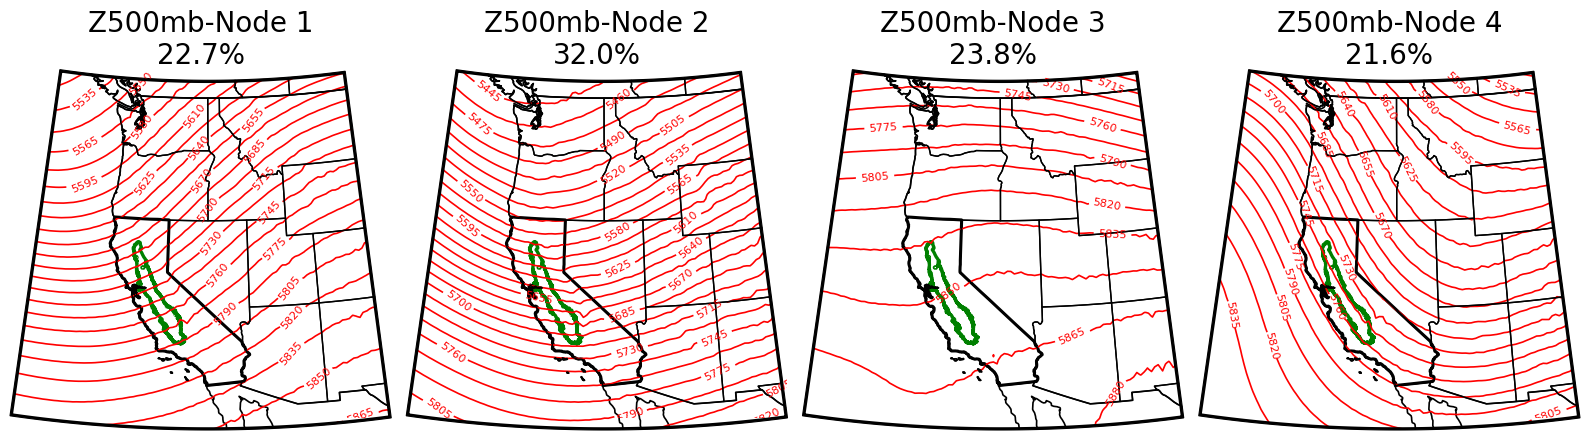

In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import geopandas as gpd
from somoclu import Somoclu

# 0) curved “box” boundary (unchanged)
lon0, lon1 = -130, -105
lat0, lat1 =   30,   50
n = 200
top    = np.column_stack((np.linspace(lon0, lon1, n), [lat1]*n))
right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
bottom = np.column_stack((np.linspace(lon1, lon0, n), [lat0]*n))
left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
pts    = np.vstack([top, right, bottom, left, top[:1]])
codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
box_path = Path(pts, codes)
def clip_to_curve(ax, linewidth=4, edgecolor="black"):
    ax.set_boundary(box_path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(box_path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

# 1) CV shapefile
cv_gdf = gpd.read_file("central_valley_alluvial_boundary_usgs.shp").to_crs(epsg=4326)
cv1_gdf = gpd.read_file("california_shapefile.shp").to_crs(epsg=4326)

# 2) load geopotential z500
ds = xr.open_dataset("z_dust.nc")
z  = ds["gh"] / 1
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

# 3) select ASON (Aug–Nov) all at once
ason = z.sel(valid_time=z.valid_time.dt.month.isin([9,10,11]))
ason = (
    ason
    .where((ason.latitude >= lat0)&(ason.latitude <= lat1), drop=True)
    .where((ason.longitude>=lon0)&(ason.longitude<=lon1), drop=True)
)

# flatten and train 2×2 SOM
data = ason.values               # shape (ntime, nlat, nlon)
ntime, nlat, nlon = data.shape
flat  = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

# compute composites & frequencies
labels = som.bmus[:,0] * 2 + som.bmus[:,1]
comps, freqs = {}, {}
for node in range(4):
    mask = (labels == node)
    freqs[node] = mask.sum() / ntime * 100
    comps[node] = np.nanmean(data[mask], axis=0) if mask.any() else np.full((nlat,nlon), np.nan)

# contour levels
vmin = min(np.nanmin(c) for c in comps.values())
vmax = max(np.nanmax(c) for c in comps.values())
levels = np.arange((vmin//15)*15, (vmax//15+1)*15 + 1, 15)

# prepare lon/lat grids & projection
lon2d, lat2d = np.meshgrid(ason.longitude, ason.latitude)
proj = ccrs.LambertConformal(central_longitude=-117, central_latitude=35,
                             standard_parallels=(33,45))

# 1×4 plot of the ASON composites
fig, axes = plt.subplots(1, 4, figsize=(16,6),
                         subplot_kw={"projection": proj})
plt.tight_layout(rect=[0,0,1,0.88])

for node, ax in enumerate(axes):
    clip_to_curve(ax)
    ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())

    cs = ax.contour(lon2d, lat2d, comps[node], levels=levels,
                    colors="red", linewidths=1.2, transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt="%d", fontsize=8)

    ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="green", facecolor="none", linewidth=2.4)
    
    ax.add_geometries(cv1_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="black", facecolor="none", linewidth=2.2)
    ax.coastlines(resolution="50m", linewidth=1.2)
    ax.add_feature(cfeature.BORDERS, linewidth=1.2)
    ax.add_feature(cfeature.STATES.with_scale("50m"),linewidth=1,zorder=2)

    ax.set_title(f"Z500mb-Node {node+1}\n{freqs[node]:.1f}%", fontsize=20, pad=4)

fig.suptitle("", fontsize=20)
fig.savefig("SON2_combined.png", dpi=300, bbox_inches="tight")
plt.show()


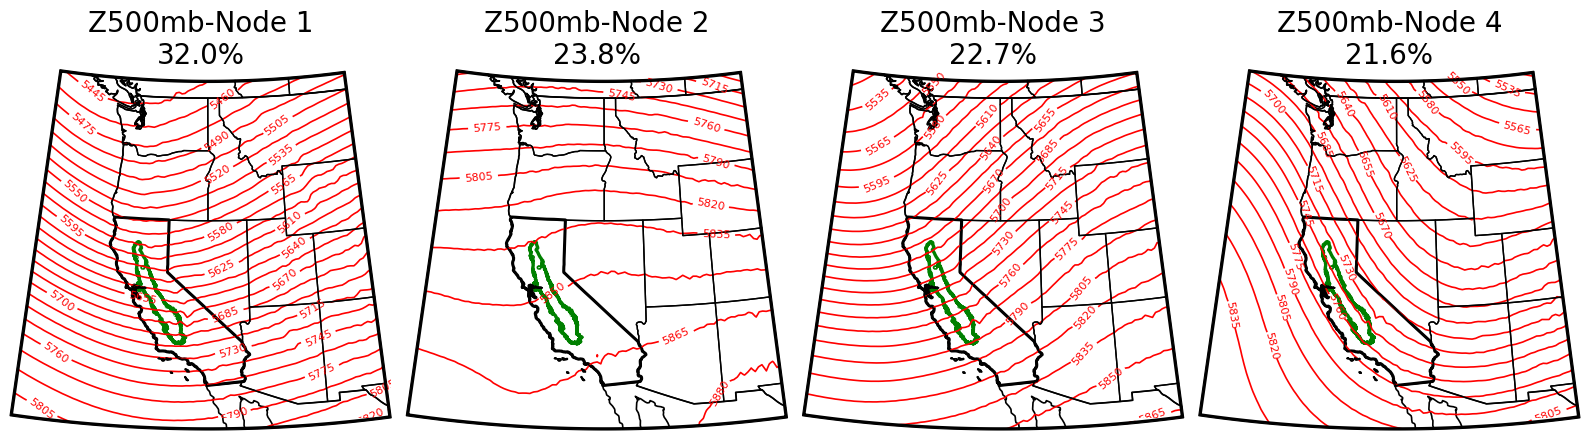

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import geopandas as gpd
from somoclu import Somoclu

# ---------------------- curved “box” boundary (unchanged) ----------------------
lon0, lon1 = -130, -105
lat0, lat1 =   30,   50
n = 200
top    = np.column_stack((np.linspace(lon0, lon1, n), [lat1]*n))
right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
bottom = np.column_stack((np.linspace(lon1, lon0, n), [lat0]*n))
left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
pts    = np.vstack([top, right, bottom, left, top[:1]])
codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
box_path = Path(pts, codes)

def clip_to_curve(ax, linewidth=4, edgecolor="black"):
    ax.set_boundary(box_path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(box_path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

# ------------------------------ CV shapefiles ---------------------------------
cv_gdf  = gpd.read_file("central_valley_alluvial_boundary_usgs.shp").to_crs(epsg=4326)
cv1_gdf = gpd.read_file("california_shapefile.shp").to_crs(epsg=4326)

# --------------------------- load geopotential z500 ----------------------------
ds = xr.open_dataset("z_dust.nc")

# try common names
time_name = "valid_time" if "valid_time" in ds.coords or "valid_time" in ds.dims else \
            "time" if "time" in ds.coords or "time" in ds.dims else None
if time_name is None:
    raise KeyError("No time coordinate named 'valid_time' or 'time' found.")

# variable name: 'gh' assumed; change here if yours differs
z = ds["gh"]
# select 500 hPa if pressure_level is present
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

# ----------------------------- subset SON season -------------------------------
ason = z.sel({time_name: ds[time_name].dt.month.isin([9,10,11])})
ason = (
    ason
    .where((ason.latitude >= lat0) & (ason.latitude <= lat1), drop=True)
    .where((ason.longitude >= lon0) & (ason.longitude <= lon1), drop=True)
)

# ---------------------------- flatten & train SOM ------------------------------
data = ason.values               # (ntime, nlat, nlon)
ntime, nlat, nlon = data.shape
flat  = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

# ------------------------- composites & frequencies ----------------------------
# Somoclu BMUs are (row, col). Convert to a single node index 0..3.
labels = som.bmus[:,0] * 2 + som.bmus[:,1]

comps, freqs = {}, {}
for node in range(4):
    mask = (labels == node)
    freqs[node] = mask.sum() / ntime * 100.0
    comps[node] = np.nanmean(data[mask], axis=0) if mask.any() else np.full((nlat, nlon), np.nan)

# ------------------------------- contour levels --------------------------------
vmin = min(np.nanmin(c) for c in comps.values())
vmax = max(np.nanmax(c) for c in comps.values())
levels = np.arange((vmin//15)*15, (vmax//15+1)*15 + 1, 15)

# ---------------------------- grids & projection --------------------------------
lon2d, lat2d = np.meshgrid(ason.longitude, ason.latitude)
proj = ccrs.LambertConformal(central_longitude=-117, central_latitude=35,
                             standard_parallels=(33, 45))

# ------------------- ORDER NODES BY FREQUENCY (DESCENDING) ---------------------
sorted_nodes = sorted(freqs.keys(), key=lambda n: freqs[n], reverse=True)
# After this, rank=1 is the most frequent, rank=4 is the least frequent.

# ------------------------------- plotting --------------------------------------
fig, axes = plt.subplots(1, 4, figsize=(16, 6), subplot_kw={"projection": proj})
plt.tight_layout(rect=[0, 0, 1, 0.88])

for rank, node in enumerate(sorted_nodes, start=1):
    ax = axes[rank-1]
    clip_to_curve(ax)
    ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())

    cs = ax.contour(lon2d, lat2d, comps[node], levels=levels,
                    colors="red", linewidths=1.2, transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt="%d", fontsize=8)

    ax.add_geometries(cv_gdf.geometry,  crs=ccrs.PlateCarree(),
                      edgecolor="green", facecolor="none", linewidth=2.4)
    ax.add_geometries(cv1_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="black", facecolor="none", linewidth=2.2)

    ax.coastlines(resolution="50m", linewidth=1.2)
    ax.add_feature(cfeature.BORDERS, linewidth=1.2)
    ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=1, zorder=2)

    # Title: Node rank by frequency + its percentage
    ax.set_title(f"Z500mb-Node {rank}\n{freqs[node]:.1f}%", fontsize=20, pad=4)

fig.suptitle("", fontsize=20)
fig.savefig("SON2_combined_sorted.png", dpi=500, bbox_inches="tight")
plt.show()


/home/precious/anaconda3/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfradial1' loading failed:
cannot import name 'DataTree' from 'xarray' (/home/precious/anaconda3/lib/python3.11/site-packages/xarray/__init__.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/precious/anaconda3/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'datamet' loading failed:
cannot import name 'DataTree' from 'xarray' (/home/precious/anaconda3/lib/python3.11/site-packages/xarray/__init__.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/precious/anaconda3/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'furuno' loading failed:
cannot import name 'DataTree' from 'xarray' (/home/precious/anaconda3/lib/python3.11/site-packages/xarray/__init__.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/precious/ana

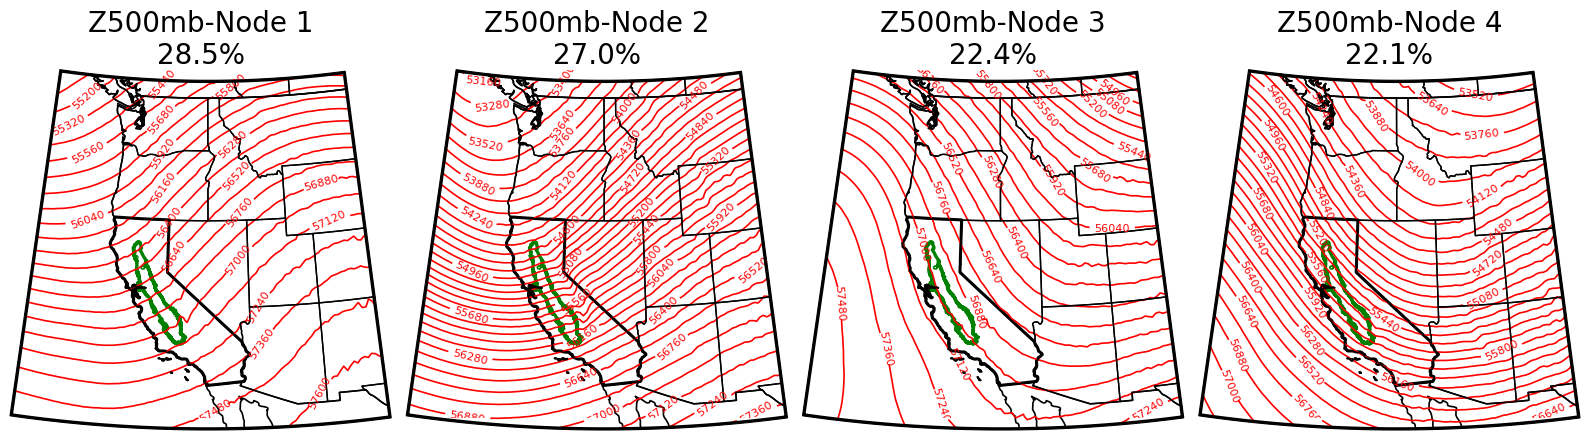

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import geopandas as gpd
from somoclu import Somoclu

# ---------------------- curved “box” boundary (unchanged) ----------------------
lon0, lon1 = -130, -105
lat0, lat1 =   30,   50
n = 200
top    = np.column_stack((np.linspace(lon0, lon1, n), [lat1]*n))
right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
bottom = np.column_stack((np.linspace(lon1, lon0, n), [lat0]*n))
left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
pts    = np.vstack([top, right, bottom, left, top[:1]])
codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
box_path = Path(pts, codes)

def clip_to_curve(ax, linewidth=4, edgecolor="black"):
    ax.set_boundary(box_path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(box_path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

# ------------------------------ CV shapefiles ---------------------------------
cv_gdf  = gpd.read_file("central_valley_alluvial_boundary_usgs.shp").to_crs(epsg=4326)
cv1_gdf = gpd.read_file("california_shapefile.shp").to_crs(epsg=4326)

# --------------------------- load geopotential z500 ----------------------------
ds = xr.open_dataset("z_dust.nc")

# try common names
time_name = "date" if "date" in ds.coords or "date" in ds.dims else \
            "time" if "time" in ds.coords or "time" in ds.dims else None
if time_name is None:
    raise KeyError("No time coordinate named 'date' or 'time' found.")

# variable name: 'gh' assumed; change here if yours differs
z = ds["z"]
# select 500 hPa if pressure_level is present
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

# ----------------------------- subset SON season -------------------------------
ason = z.sel({time_name: ds[time_name].dt.month.isin([9,10,11])})
ason = (
    ason
    .where((ason.latitude >= lat0) & (ason.latitude <= lat1), drop=True)
    .where((ason.longitude >= lon0) & (ason.longitude <= lon1), drop=True)
)

# ---------------------------- flatten & train SOM ------------------------------
data = ason.values               # (ntime, nlat, nlon)
ntime, nlat, nlon = data.shape
flat  = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(777)
som.train(flat, epochs=1000)

# ------------------------- composites & frequencies ----------------------------
# Somoclu BMUs are (row, col). Convert to a single node index 0..3.
labels = som.bmus[:,0] * 2 + som.bmus[:,1]

comps, freqs = {}, {}
for node in range(4):
    mask = (labels == node)
    freqs[node] = mask.sum() / ntime * 100.0
    comps[node] = np.nanmean(data[mask], axis=0) if mask.any() else np.full((nlat, nlon), np.nan)

# ------------------------------- contour levels --------------------------------
vmin = min(np.nanmin(c) for c in comps.values())
vmax = max(np.nanmax(c) for c in comps.values())
levels = np.arange((vmin//120)*120, (vmax//120+1)*120 + 1, 120)

# ---------------------------- grids & projection --------------------------------
lon2d, lat2d = np.meshgrid(ason.longitude, ason.latitude)
proj = ccrs.LambertConformal(central_longitude=-117, central_latitude=35,
                             standard_parallels=(33, 45))

# ------------------- ORDER NODES BY FREQUENCY (DESCENDING) ---------------------
sorted_nodes = sorted(freqs.keys(), key=lambda n: freqs[n], reverse=True)
# After this, rank=1 is the most frequent, rank=4 is the least frequent.

# ------------------------------- plotting --------------------------------------
fig, axes = plt.subplots(1, 4, figsize=(16, 6), subplot_kw={"projection": proj})
plt.tight_layout(rect=[0, 0, 1, 0.88])

for rank, node in enumerate(sorted_nodes, start=1):
    ax = axes[rank-1]
    clip_to_curve(ax)
    ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())

    cs = ax.contour(lon2d, lat2d, comps[node], levels=levels,
                    colors="red", linewidths=1.2, transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt="%d", fontsize=8)

    ax.add_geometries(cv_gdf.geometry,  crs=ccrs.PlateCarree(),
                      edgecolor="green", facecolor="none", linewidth=2.4)
    ax.add_geometries(cv1_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="black", facecolor="none", linewidth=2.2)

    ax.coastlines(resolution="50m", linewidth=1.2)
    ax.add_feature(cfeature.BORDERS, linewidth=1.2)
    ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=1, zorder=2)

    # Title: Node rank by frequency + its percentage
    ax.set_title(f"Z500mb-Node {rank}\n{freqs[node]:.1f}%", fontsize=20, pad=4)

fig.suptitle("", fontsize=20)
fig.savefig("SON-5.png", dpi=500, bbox_inches="tight")
plt.show()


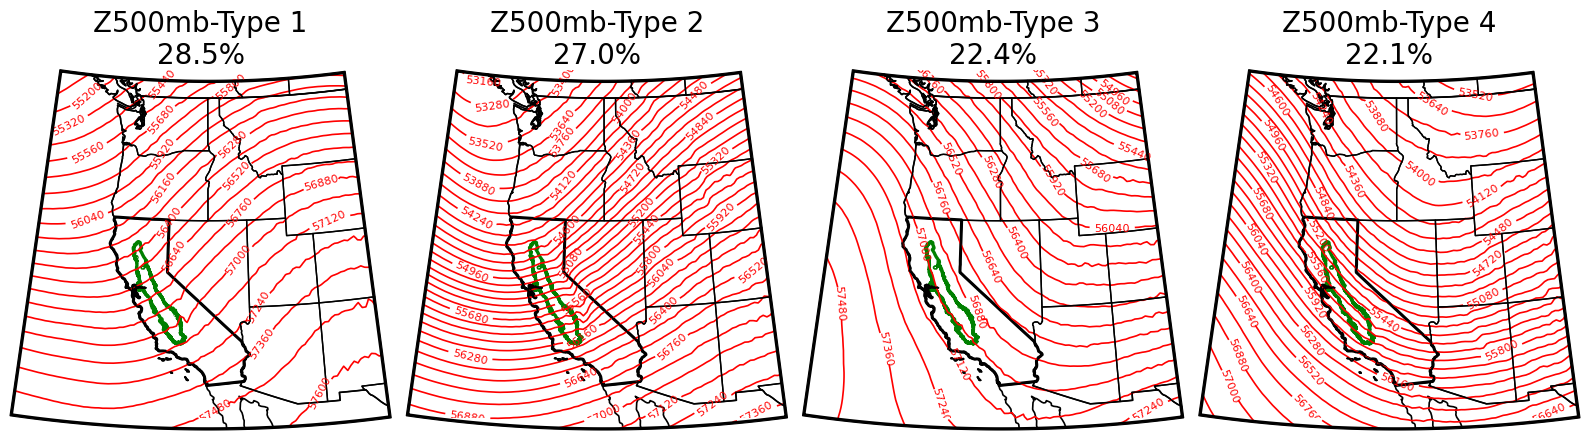

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import geopandas as gpd
from somoclu import Somoclu

# ---------------------- curved “box” boundary (unchanged) ----------------------
lon0, lon1 = -130, -105
lat0, lat1 =   30,   50
n = 200
top    = np.column_stack((np.linspace(lon0, lon1, n), [lat1]*n))
right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
bottom = np.column_stack((np.linspace(lon1, lon0, n), [lat0]*n))
left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
pts    = np.vstack([top, right, bottom, left, top[:1]])
codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
box_path = Path(pts, codes)

def clip_to_curve(ax, linewidth=4, edgecolor="black"):
    ax.set_boundary(box_path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(box_path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

# ------------------------------ CV shapefiles ---------------------------------
cv_gdf  = gpd.read_file("central_valley_alluvial_boundary_usgs.shp").to_crs(epsg=4326)
cv1_gdf = gpd.read_file("california_shapefile.shp").to_crs(epsg=4326)

# --------------------------- load geopotential z500 ----------------------------
ds = xr.open_dataset("z_dust.nc")

# try common names
time_name = "date" if "date" in ds.coords or "date" in ds.dims else \
            "time" if "time" in ds.coords or "time" in ds.dims else None
if time_name is None:
    raise KeyError("No time coordinate named 'date' or 'time' found.")

# variable name: 'gh' assumed; change here if yours differs
z = ds["z"]
# select 500 hPa if pressure_level is present
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

# ----------------------------- subset SON season -------------------------------
ason = z.sel({time_name: ds[time_name].dt.month.isin([9,10,11])})
ason = (
    ason
    .where((ason.latitude >= lat0) & (ason.latitude <= lat1), drop=True)
    .where((ason.longitude >= lon0) & (ason.longitude <= lon1), drop=True)
)

# ---------------------------- flatten & train SOM ------------------------------
data = ason.values               # (ntime, nlat, nlon)
ntime, nlat, nlon = data.shape
flat  = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(777)
som.train(flat, epochs=1000)

# ------------------------- composites & frequencies ----------------------------
# Somoclu BMUs are (row, col). Convert to a single node index 0..3.
labels = som.bmus[:,0] * 2 + som.bmus[:,1]

comps, freqs = {}, {}
for node in range(4):
    mask = (labels == node)
    freqs[node] = mask.sum() / ntime * 100.0
    comps[node] = np.nanmean(data[mask], axis=0) if mask.any() else np.full((nlat, nlon), np.nan)

# ------------------------------- contour levels --------------------------------
vmin = min(np.nanmin(c) for c in comps.values())
vmax = max(np.nanmax(c) for c in comps.values())
levels = np.arange((vmin//120)*120, (vmax//120+1)*120 + 1, 120)

# ---------------------------- grids & projection --------------------------------
lon2d, lat2d = np.meshgrid(ason.longitude, ason.latitude)
proj = ccrs.LambertConformal(central_longitude=-117, central_latitude=35,
                             standard_parallels=(33, 45))

# ------------------- ORDER NODES BY FREQUENCY (DESCENDING) ---------------------
sorted_nodes = sorted(freqs.keys(), key=lambda n: freqs[n], reverse=True)
# After this, rank=1 is the most frequent, rank=4 is the least frequent.

# ------------------------------- plotting --------------------------------------
fig, axes = plt.subplots(1, 4, figsize=(16, 6), subplot_kw={"projection": proj})
plt.tight_layout(rect=[0, 0, 1, 0.88])

for rank, node in enumerate(sorted_nodes, start=1):
    ax = axes[rank-1]
    clip_to_curve(ax)
    ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())

    cs = ax.contour(lon2d, lat2d, comps[node], levels=levels,
                    colors="red", linewidths=1.2, transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt="%d", fontsize=8)

    ax.add_geometries(cv_gdf.geometry,  crs=ccrs.PlateCarree(),
                      edgecolor="green", facecolor="none", linewidth=2.4)
    ax.add_geometries(cv1_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="black", facecolor="none", linewidth=2.2)

    ax.coastlines(resolution="50m", linewidth=1.2)
    ax.add_feature(cfeature.BORDERS, linewidth=1.2)
    ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=1, zorder=2)

    # Title: Node rank by frequency + its percentage
    ax.set_title(f"Z500mb-Type {rank}\n{freqs[node]:.1f}%", fontsize=20, pad=4)

fig.suptitle("", fontsize=20)
fig.savefig("SON-5.png", dpi=500, bbox_inches="tight")
plt.show()


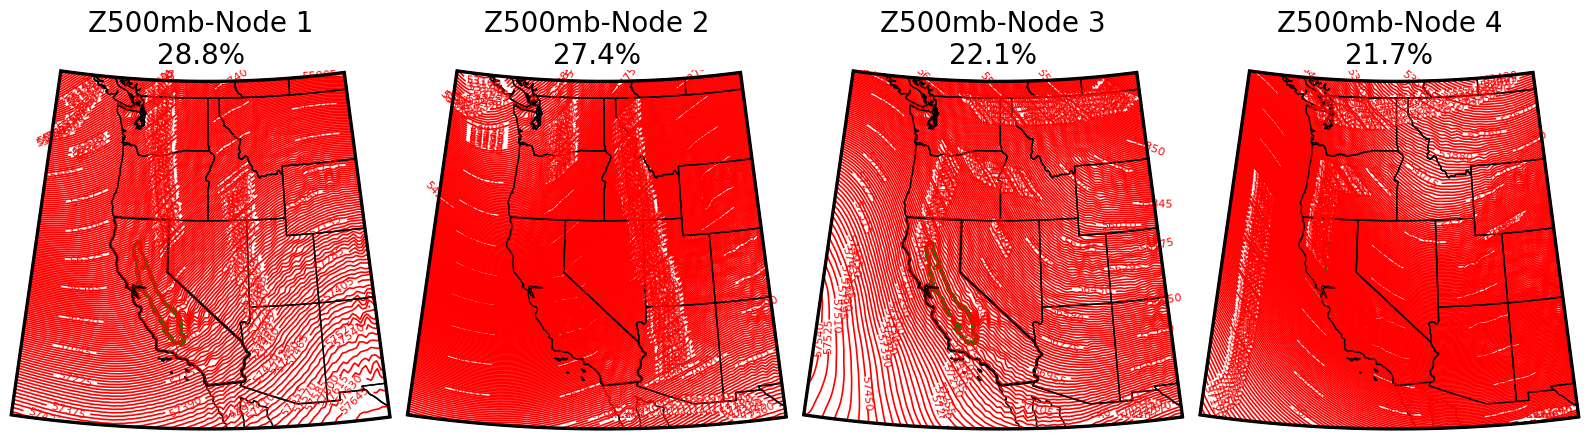

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import geopandas as gpd
from somoclu import Somoclu

# ---------------------- curved “box” boundary (unchanged) ----------------------
lon0, lon1 = -130, -105
lat0, lat1 =   30,   50
n = 200
top    = np.column_stack((np.linspace(lon0, lon1, n), [lat1]*n))
right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
bottom = np.column_stack((np.linspace(lon1, lon0, n), [lat0]*n))
left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
pts    = np.vstack([top, right, bottom, left, top[:1]])
codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
box_path = Path(pts, codes)

def clip_to_curve(ax, linewidth=4, edgecolor="black"):
    ax.set_boundary(box_path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(box_path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

# ------------------------------ CV shapefiles ---------------------------------
cv_gdf  = gpd.read_file("central_valley_alluvial_boundary_usgs.shp").to_crs(epsg=4326)
cv1_gdf = gpd.read_file("california_shapefile.shp").to_crs(epsg=4326)

# --------------------------- load geopotential z500 ----------------------------
ds = xr.open_dataset("z_dust.nc")

# try common names
time_name = "valid_time" if "valid_time" in ds.coords or "valid_time" in ds.dims else \
            "date" if "date" in ds.coords or "date" in ds.dims else None
if time_name is None:
    raise KeyError("No time coordinate named 'valid_time' or 'time' found.")

# variable name: 'gh' assumed; change here if yours differs
z = ds["z"]
# select 500 hPa if pressure_level is present
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

# ----------------------------- subset SON season -------------------------------
ason = z.sel({time_name: ds[time_name].dt.month.isin([9,10,11])})
ason = (
    ason
    .where((ason.latitude >= lat0) & (ason.latitude <= lat1), drop=True)
    .where((ason.longitude >= lon0) & (ason.longitude <= lon1), drop=True)
)

# ---------------------------- flatten & train SOM ------------------------------
data = ason.values               # (ntime, nlat, nlon)
ntime, nlat, nlon = data.shape
flat  = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

# ------------------------- composites & frequencies ----------------------------
# Somoclu BMUs are (row, col). Convert to a single node index 0..3.
labels = som.bmus[:,0] * 2 + som.bmus[:,1]

comps, freqs = {}, {}
for node in range(4):
    mask = (labels == node)
    freqs[node] = mask.sum() / ntime * 100.0
    comps[node] = np.nanmean(data[mask], axis=0) if mask.any() else np.full((nlat, nlon), np.nan)

# ------------------------------- contour levels --------------------------------
vmin = min(np.nanmin(c) for c in comps.values())
vmax = max(np.nanmax(c) for c in comps.values())
levels = np.arange((vmin//15)*15, (vmax//15+1)*15 + 1, 15)

# ---------------------------- grids & projection --------------------------------
lon2d, lat2d = np.meshgrid(ason.longitude, ason.latitude)
proj = ccrs.LambertConformal(central_longitude=-117, central_latitude=35,
                             standard_parallels=(33, 45))

# ------------------- ORDER NODES BY FREQUENCY (DESCENDING) ---------------------
sorted_nodes = sorted(freqs.keys(), key=lambda n: freqs[n], reverse=True)
# After this, rank=1 is the most frequent, rank=4 is the least frequent.

# ------------------------------- plotting --------------------------------------
fig, axes = plt.subplots(1, 4, figsize=(16, 6), subplot_kw={"projection": proj})
plt.tight_layout(rect=[0, 0, 1, 0.88])

for rank, node in enumerate(sorted_nodes, start=1):
    ax = axes[rank-1]
    clip_to_curve(ax)
    ax.set_extent([lon0, lon1, lat0, lat1], crs=ccrs.PlateCarree())

    cs = ax.contour(lon2d, lat2d, comps[node], levels=levels,
                    colors="red", linewidths=1.2, transform=ccrs.PlateCarree())
    ax.clabel(cs, fmt="%d", fontsize=8)

    ax.add_geometries(cv_gdf.geometry,  crs=ccrs.PlateCarree(),
                      edgecolor="green", facecolor="none", linewidth=2.4)
    ax.add_geometries(cv1_gdf.geometry, crs=ccrs.PlateCarree(),
                      edgecolor="black", facecolor="none", linewidth=2.2)

    ax.coastlines(resolution="50m", linewidth=1.2)
    ax.add_feature(cfeature.BORDERS, linewidth=1.2)
    ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=1, zorder=2)

    # Title: Node rank by frequency + its percentage
    ax.set_title(f"Z500mb-Node {rank}\n{freqs[node]:.1f}%", fontsize=20, pad=4)

fig.suptitle("", fontsize=20)
fig.savefig("AUGUST5555_combined_sorted.png", dpi=500, bbox_inches="tight")
plt.show()
